In [3]:
import json
import time
import pandas as pd
from openai import OpenAI
from tqdm import tqdm
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report
from collections import Counter

# Import TẤT CẢ các mẫu prompt từ file prompt.py
from prompt import *

In [ ]:
# API Key
api_key = "..."  # Thay thế bằng API Key của bạn

# 1. Khởi tạo Client với API Key
client = OpenAI(api_key=api_key)

# 2. Định nghĩa các model và các kịch bản prompt
MODELS_TO_COMPARE = ["gpt-3.5-turbo", "gpt-4o-mini"]
PROMPTS_TO_TEST = {
    "English Prompt (Zero-shot)": ENGLISH_ZERO,
    "English Prompt (1-shot)": ENGLISH_ONE,
    "English Prompt (3-shot)": ENGLISH_THREE,
    "Persian Prompt (Zero-shot)": PERSIAN_ZERO,
    "Persian Prompt (1-shot)": PERSIAN_ONE,
    "Persian Prompt (3-shot)": PERSIAN_THREE,
}

# 3. Tải toàn bộ dữ liệu từ file sentiment.jsonl
try:
    full_data = []
    # Dùng đúng tên file dữ liệu bạn đã cung cấp
    with open('sentiment.jsonl', 'r', encoding='utf-8') as reader:
        for line in reader:
            full_data.append(json.loads(line))
    
   
    SAMPLE_SIZE = 190
    all_data = full_data[:SAMPLE_SIZE] 
    
    print(f" Đã tải thành công {len(full_data)} review.")
    print(f" sử dụng {len(all_data)} review đầu tiên để kiểm tra.")

except FileNotFoundError:
    print(" Lỗi: Không tìm thấy file 'sentiment.jsonl'.")

 Đã tải thành công 190 review.
 sử dụng 190 review đầu tiên để kiểm tra.


In [5]:
def get_answer_from_model(prompt, model_name):
    """
    Hàm này nhận một prompt và tên model, sau đó trả về câu trả lời.
    """
    try:
        response = client.chat.completions.create(
          model=model_name,
          messages=[
                {"role": "system", "content": "You are an expert in sentiment analysis for the Persian language."},
                {"role": "user", "content": prompt}
            ],
          temperature=0,
          max_tokens=10 
        )
        return response.choices[0].message.content.strip()
    except Exception as e:
        print(f"\nLỗi khi gọi model {model_name}: {e}")
        return "ERROR"

In [6]:
acceptable_classes = [
    "POSITIVE",
    "NEGATIVE",
    "NEUTRAL",
    "OTHER"
]

In [7]:
def post_proccess_response(response):
    response = response.upper()
    for label in acceptable_classes:
        if label in response:
            return label
    return "OTHER"

In [8]:
def calculate_metrics(actual, predicted):
    accuracy = accuracy_score(actual, predicted)
    f1 = f1_score(actual, predicted, average='weighted', zero_division=0)
    precision = precision_score(actual, predicted, average='weighted', zero_division=0)
    recall = recall_score(actual, predicted, average='weighted', zero_division=0)

    classes = list(set(actual + predicted))
    if 'All Classes' not in classes:
        classes.append('All Classes')
        
    metrics = ['Accuracy', 'F1 Score', 'Precision', 'Recall']
    probability_table = pd.DataFrame(index=metrics, columns=classes)

    for class_label in classes:
        if class_label == 'All Classes':
            probability_table[class_label]["F1 Score"] = f1
            probability_table[class_label]["Precision"] = precision
            probability_table[class_label]["Recall"] = recall
        else:
            class_precision = precision_score(actual, predicted, labels=[class_label], average='weighted', zero_division=0)
            class_recall = recall_score(actual, predicted, labels=[class_label], average='weighted', zero_division=0)
            class_f1 = f1_score(actual, predicted, labels=[class_label], average='weighted', zero_division=0)
            probability_table[class_label]["F1 Score"] = class_f1
            probability_table[class_label]["Precision"] = class_precision
            probability_table[class_label]["Recall"] = class_recall
            
    probability_table.fillna(value="-", inplace = True)
    probability_table['All Classes']["Accuracy"] = accuracy
    return probability_table

In [9]:
# Dictionary để lưu kết quả cuối cùng
final_results = {}

# Bắt đầu vòng lặp lớn
for model_name in MODELS_TO_COMPARE:
    print(f"============== BẮT ĐẦU MODEL: {model_name} ==============")
    final_results[model_name] = {}
    
    # Vòng lặp bên trong: chạy qua từng loại prompt
    for prompt_name, prompt_template in PROMPTS_TO_TEST.items():
        print(f"--- 🚀 Đang chạy kịch bản: {prompt_name} ---")
        
        model_predictions_raw = []
        
        # Chạy qua toàn bộ dữ liệu mẫu
        for sample in tqdm(all_data, desc=f"Querying {prompt_name}"):
            # Lưu ý: file prompt.py này dùng {review}
            prompt = prompt_template.format(review=sample['review'])
            answer = get_answer_from_model(prompt, model_name)
            model_predictions_raw.append(answer)
            time.sleep(1)

        # Lưu lại danh sách các câu trả lời thô của model
        final_results[model_name][prompt_name] = model_predictions_raw
        print(f"--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: {prompt_name} ---\n")

print("✨ Đã hoàn thành tất cả các thử nghiệm.")

============== BẮT ĐẦU MODEL: gpt-3.5-turbo ==============
--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 190/190 [05:14<00:00,  1.65s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 190/190 [05:08<00:00,  1.62s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 190/190 [05:12<00:00,  1.65s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 190/190 [05:05<00:00,  1.61s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 190/190 [05:17<00:00,  1.67s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 190/190 [05:15<00:00,  1.66s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

============== BẮT ĐẦU MODEL: gpt-4o-mini ==============
--- 🚀 Đang chạy kịch bản: English Prompt (Zero-shot) ---


Querying English Prompt (Zero-shot): 100%|██████████| 190/190 [05:23<00:00,  1.70s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (Zero-shot) ---

--- 🚀 Đang chạy kịch bản: English Prompt (1-shot) ---


Querying English Prompt (1-shot): 100%|██████████| 190/190 [05:13<00:00,  1.65s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (1-shot) ---

--- 🚀 Đang chạy kịch bản: English Prompt (3-shot) ---


Querying English Prompt (3-shot): 100%|██████████| 190/190 [05:30<00:00,  1.74s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: English Prompt (3-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (Zero-shot) ---


Querying Persian Prompt (Zero-shot): 100%|██████████| 190/190 [05:28<00:00,  1.73s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (Zero-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (1-shot) ---


Querying Persian Prompt (1-shot): 100%|██████████| 190/190 [05:40<00:00,  1.79s/it]


--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (1-shot) ---

--- 🚀 Đang chạy kịch bản: Persian Prompt (3-shot) ---


Querying Persian Prompt (3-shot): 100%|██████████| 190/190 [06:14<00:00,  1.97s/it]

--- 🎉 Hoàn thành thu thập dữ liệu cho kịch bản: Persian Prompt (3-shot) ---

✨ Đã hoàn thành tất cả các thử nghiệm.


In [13]:
print(prompt)

جمله زیر نظر یک شخص است. این جمله به زبان فارسی است. بار یا احساس موجود در این جمله را شناسایی کن.
پاسخ‌ های ممکن کلمات روبرو هستند: POSITIVE, NEUTRAL, NEGATIVE, OTHER.
زمانی که جمله دارای احساس خاصی نیست یا شامل احساسات مختلف است از OTHER استفاده کن

مثال ها:

مثال 1:
نظر: طعم بد . بوی بد . فقط قیمتش خوبه .
احساس: NEGATIVE

مثال 2:
نظر: بعد از ۵ دقیقه مزه اش رو از دست میده
احساس: NEGATIVE

مثال 3:
نظر: طرفش خیلی نازکه تو دست نمیشه نگه داشت
احساس: NEGATIVE

مثال 4:
نظر: اول هلو سان کوییک بعد یه مدل از سن ایچ
احساس: NEUTRAL

مثال 5:
نظر: با بقیه چایی ها هیچ فرقی نداره چه طعم چه رنگ
احساس: NEUTRAL

مثال 6:
نظر: در بسته بندی بهتری اگر عرضه شود خیلی بهتر است
احساس: NEUTRAL

مثال 7:
نظر: خوبه مثل بعضی از مربا ها ابکی نیست
احساس: POSITIVE

مثال 8:
نظر: خوب بود و در باز بودن و طعم خوبی داشت
احساس: POSITIVE

مثال 9:
نظر: عطر و طعمش سلیقه ایه . من که راضی بودم
احساس: POSITIVE

مثال 10:
نظر: خیلی خوب بود اما ظرفش یه کم پر دردسر بود .
احساس: OTHER

مثال 11:
نظر: مزه اش یه جور خاصه تند تند نیس ولی

In [12]:
from sklearn.metrics import classification_report, f1_score
import pandas as pd

# Danh sách các nhãn hợp lệ (đảm bảo biến này tồn tại)
acceptable_classes = [
    "POSITIVE",
    "NEGATIVE",
    "NEUTRAL",
    "OTHER"
]

# SỬA LỖI Ở ĐÂY: Lấy đáp án đúng từ biến 'all_data'
true_answers = [sample['output'] for sample in all_data]

# DataFrame để lưu trữ chỉ số F1-score cho bảng tóm tắt
f1_results = {}

print("\n\n📊=============== BÁO CÁO CHI TIẾT HIỆU NĂNG PHÂN TÍCH CẢM XÚC ===============📊")

# Vòng lặp qua kết quả của từng model
for model_name, prompt_results in final_results.items():
    f1_results[model_name] = {}
    print(f"\n\n{'='*30}\n Báo cáo cho Model: {model_name} \n{'='*30}")
    
    # Vòng lặp qua từng kịch bản prompt của model đó
    for prompt_name, raw_predictions in prompt_results.items():
        # Sử dụng hàm post_proccess_response để chuẩn hóa dự đoán
        processed_predictions = [post_proccess_response(pred) for pred in raw_predictions]
        
        # Tính toán F1-score (weighted) để lưu lại
        f1 = f1_score(true_answers, processed_predictions, average='weighted', zero_division=0) * 100
        f1_results[model_name][prompt_name] = f1
        
        print(f"\n--- Kịch bản: {prompt_name} ---")
        print(f" F1-score (Weighted): {f1:.2f}%")
        # In báo cáo chi tiết (precision, recall, f1-score) cho kịch bản này
        print(classification_report(true_answers, processed_predictions, zero_division=0, labels=acceptable_classes))

# Tạo DataFrame từ kết quả đã thu thập
summary_df = pd.DataFrame(f1_results)
summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)
summary_df.columns.name = "Model"
summary_df.index.name = "Prompt / Kịch bản"

print("\n\n📊=============== BẢNG TÓM TẮT F1-SCORE ===============📊")
print(summary_df.to_markdown())



📊=============== BÁO CÁO CHI TIẾT HIỆU NĂNG PHÂN TÍCH CẢM XÚC ===============📊


 Báo cáo cho Model: gpt-3.5-turbo 

--- Kịch bản: English Prompt (Zero-shot) ---
 F1-score (Weighted): 81.91%
              precision    recall  f1-score   support

    POSITIVE       0.92      0.92      0.92        97
    NEGATIVE       0.79      0.88      0.83        66
     NEUTRAL       0.25      1.00      0.40         1
       OTHER       0.56      0.35      0.43        26

    accuracy                           0.83       190
   macro avg       0.63      0.79      0.65       190
weighted avg       0.82      0.83      0.82       190


--- Kịch bản: English Prompt (1-shot) ---
 F1-score (Weighted): 87.03%
              precision    recall  f1-score   support

    POSITIVE       0.96      0.91      0.93        97
    NEGATIVE       0.89      0.89      0.89        66
     NEUTRAL       0.20      1.00      0.33         1
       OTHER       0.59      0.62      0.60        26

    accuracy                

C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_17496\3825645946.py:41: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  summary_df = summary_df.applymap(lambda x: f"{x:.2f}%" if isinstance(x, (float, int)) else x)




📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (SENTIMENT) ===============📈


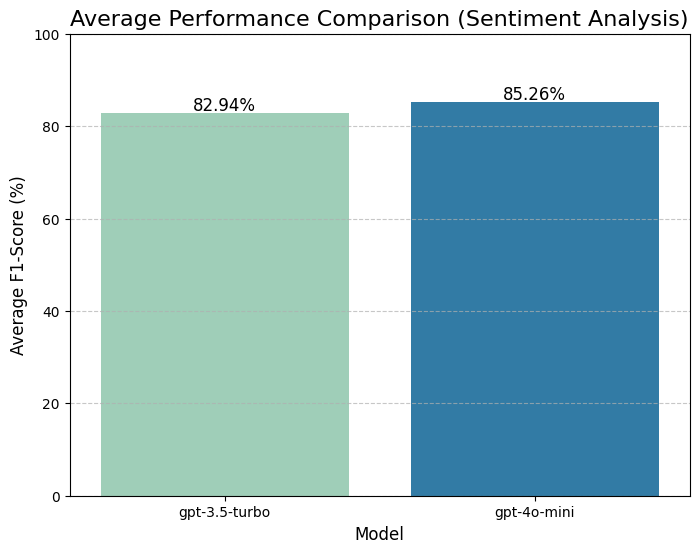

In [14]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sentiment_data = {
    'Experiment': [
        'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
        'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
        'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
    ] * 2,
    'Model': [
        'gpt-3.5-turbo'] * 6 + ['gpt-4o-mini'] * 6
    ,
    'F1-Score': [
        # gpt-3.5-turbo scores (đã sắp xếp lại)
        81.91, 81.06, 87.03, 84.29, 85.16, 78.18,
        # gpt-4o-mini scores (lấy từ bảng của bạn, đã sắp xếp lại)
        85.49, 86.83, 85.74, 84.83, 86.46, 82.21
    ]
}

df_sentiment = pd.DataFrame(sentiment_data)

print("\n\n📈=============== BIỂU ĐỒ SO SÁNH HIỆU SUẤT TRUNG BÌNH (SENTIMENT) ===============📈")

# Nhóm theo model và tính điểm F1-score trung bình
df_summary = df_sentiment.groupby('Model')['F1-Score'].mean().reset_index()

# Vẽ biểu đồ
plt.figure(figsize=(8, 6))
sns.barplot(x='Model', y='F1-Score', data=df_summary, hue='Model', palette='YlGnBu', legend=False)

# Tùy chỉnh biểu đồ
plt.title('Average Performance Comparison (Sentiment Analysis)', fontsize=16)
plt.ylabel('Average F1-Score (%)', fontsize=12)
plt.xlabel('Model', fontsize=12)
plt.ylim(0, 100)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Hiển thị giá trị trên mỗi cột
for p in plt.gca().patches:
    plt.gca().annotate(f"{p.get_height():.2f}%", (p.get_x() + p.get_width() / 2., p.get_height()),
                       ha='center', va='center', fontsize=12, color='black', xytext=(0, 5),
                       textcoords='offset points')

plt.show()

In [15]:
# Hiển thị bảng tóm tắt chi tiết
print("\n\n📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (SENTIMENT) ===============📊")
# Tạo thứ tự mong muốn cho các hàng
prompt_order = [
    'English Prompt (Zero-shot)', 'Persian Prompt (Zero-shot)',
    'English Prompt (1-shot)', 'Persian Prompt (1-shot)',
    'English Prompt (3-shot)', 'Persian Prompt (3-shot)'
]
# Sắp xếp lại DataFrame theo thứ tự đã định
df_sentiment['Experiment'] = pd.Categorical(df_sentiment['Experiment'], categories=prompt_order, ordered=True)
df_sentiment = df_sentiment.sort_values('Experiment')

# Tạo bảng pivot
pivot_detailed = df_sentiment.pivot_table(index='Experiment', columns='Model', values='F1-Score')
print(pivot_detailed.to_markdown(floatfmt=".2f"))



📊=============== BẢNG TÓM TẮT HIỆU SUẤT CHI TIẾT (SENTIMENT) ===============📊
| Experiment                 |   gpt-3.5-turbo |   gpt-4o-mini |
|:---------------------------|----------------:|--------------:|
| English Prompt (Zero-shot) |           81.91 |         85.49 |
| Persian Prompt (Zero-shot) |           81.06 |         86.83 |
| English Prompt (1-shot)    |           87.03 |         85.74 |
| Persian Prompt (1-shot)    |           84.29 |         84.83 |
| English Prompt (3-shot)    |           85.16 |         86.46 |
| Persian Prompt (3-shot)    |           78.18 |         82.21 |


C:\Users\GiaHyTran\AppData\Local\Temp\ipykernel_17496\1108150414.py:14: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  pivot_detailed = df_sentiment.pivot_table(index='Experiment', columns='Model', values='F1-Score')
